In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline # plot in cell
from sklearn import metrics
import pandas as pd
from scipy import signal
from scipy import stats

import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# for svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

In [2]:
import pandas as pd

data = pd.read_excel(r'F:\Program\OneDrive\TLNC\ISI\data\data.xlsx')
data.columns
data

Index(['Person', 'State', 'x', 'y', 'z'], dtype='object')

,Person,State,x,y,z
0,33.0,Jogging,-0.694638,12.680544,0.503953
1,33.0,Jogging,5.012288,11.264028,0.953424
2,33.0,Jogging,4.903325,10.882658,-0.081722
3,33.0,Jogging,-0.612916,18.496431,3.023717
4,33.0,Jogging,-1.184970,12.108489,7.205164
...,...,...,...,...,...
1048570,7.0,Standing,-8.080000,5.090000,-0.690000
1048571,7.0,Standing,-8.120000,5.520000,-0.800000
1048572,7.0,Standing,-7.890000,5.790000,-0.720000
1048573,7.0,Standing,-7.890000,5.980000,-0.270000


In [3]:
G = 9.81
data['x'] = data['x'].div(G)
data['y'] = data['y'].div(G)
data['z'] = data['z'].div(G)
data

,Person,State,x,y,z
0,33.0,Jogging,-0.070809,1.292614,0.051371
1,33.0,Jogging,0.510937,1.148219,0.097189
2,33.0,Jogging,0.499829,1.109343,-0.008330
3,33.0,Jogging,-0.062479,1.885467,0.308228
4,33.0,Jogging,-0.120792,1.234301,0.734471
...,...,...,...,...,...
1048570,7.0,Standing,-0.823649,0.518858,-0.070336
1048571,7.0,Standing,-0.827727,0.562691,-0.081549
1048572,7.0,Standing,-0.804281,0.590214,-0.073394
1048573,7.0,Standing,-0.804281,0.609582,-0.027523


In [4]:
data = data.drop(columns = 'Person')
df = data.groupby(['State'])
df.first()

,x,y,z
State,,,
Downstairs,-0.004165,0.508160,0.663662
Jogging,-0.070809,1.292614,0.051371
Sitting,0.265036,0.984709,0.105520
Standing,-0.191641,1.004077,-0.023603
Upstairs,1.031592,0.441516,-0.385979
Walking,0.086082,0.816388,0.284625


In [5]:
Downstairs = df.get_group(('Downstairs'))
Jogging = df.get_group(('Jogging'))
Upstairs = df.get_group(('Upstairs'))
Walking = df.get_group(('Walking'))

len(Downstairs)
len(Jogging)
len(Upstairs)
len(Walking)

97813

325975

118589

406776

In [6]:
Walking.isnull().sum().sum()
Jogging.isnull().sum().sum()
Upstairs.isnull().sum().sum()
Downstairs.isnull().sum().sum()


1

0

0

0

In [7]:
#Check nan value & remove 
len(Walking.index)

Walking = Walking.dropna()
Walking.index = pd.RangeIndex(len(Walking.index))
len(Walking.index)
Walking.isnull().sum().sum()

type(Walking)

406776

406775

0

pandas.core.frame.DataFrame

In [9]:
# Split dataset to 2 parts: Train (60%) - Test (40%)\n",
# 200 samples/frame

window_size = 200
stride = 100 #step

# range (start, stop, step)

X_walk_train = [Walking[i:i+window_size] for i in range(0, int(len(Walking)*0.6), stride)]
X_walk_test = [Walking[i:i+window_size] for i in range(int(len(Walking)*0.6), len(Walking),stride)
                                           if i+window_size<=len(Walking)]

X_jog_train = [Jogging[i:i+window_size] for i in range(0, int(len(Jogging)*0.6), stride)] 
X_jog_test = [Jogging[i:i+window_size] for i in range(int(len(Jogging)*0.6), len(Jogging), stride) 
                                            if i+window_size<=len(Jogging)]

X_up_train = [Upstairs[i:i+window_size] for i in range(0, int(len(Upstairs)*0.6), stride)] 
X_up_test = [Upstairs[i:i+window_size] for i in range(int(len(Upstairs)*0.6), len(Upstairs), stride) 
                                            if i+window_size<=len(Upstairs)]

X_down_train = [Downstairs[i:i+window_size] for i in range(0, int(len(Downstairs)*0.6), stride)] 
X_down_test = [Downstairs[i:i+window_size] for i in range(int(len(Downstairs)*0.6), len(Downstairs), stride) 
                                            if i+window_size<=len(Downstairs)]

print ('X_walk_train: ', len(X_walk_train))
print ('X_walk_test: ', len(X_walk_test))

print ('X_jog_train: ', len(X_jog_train))
print ('X_jog_test: ', len(X_jog_test))

print ('X_up_train: ', len(X_up_train))
print ('X_up_test: ', len(X_up_test))

print ('X_down_train: ', len(X_down_train))
print ('X_down_test: ', len(X_down_test))



X_walk_train:  2441
X_walk_test:  1626
X_jog_train:  1956
X_jog_test:  1302
X_up_train:  712
X_up_test:  473
X_down_train:  587
X_down_test:  390


In [10]:
train_data = []
train_label = []

test_data = []
test_label = []
  
for acts in X_walk_train:
    train_data.append(acts)
    train_label.append(0)

for acts in X_jog_train:
    train_data.append(acts)
    train_label.append(1)

for acts in X_up_train:
    train_data.append(acts)
    train_label.append(2)

for acts in X_down_train:
    train_data.append(acts)
    train_label.append(3)


print('train-data length: ', len(train_data) )
print('train-label length: ', len(train_label) )
#print(train_label)
      
# For TEST

for acts in X_walk_test:
    test_data.append(acts)
    test_label.append(0)

for acts in X_jog_test:
    test_data.append(acts)
    test_label.append(1)

for acts in X_up_test:
    test_data.append(acts)
    test_label.append(2)

for acts in X_down_test:
    test_data.append(acts)
    test_label.append(3)

print('test-data length: ', len(test_data))
print('test-label length: ', len(test_label))

train-data length:  5696
train-label length:  5696
test-data length:  3791
test-label length:  3791


In [11]:

def featuresFromBuffer(at):
    feat = np.zeros(15)   
    
    x = np.array(at.iloc[:,0], dtype=np.float64)   
    y = np.array(at.iloc[:,1], dtype=np.float64)   
    z = np.array(at.iloc[:,2], dtype=np.float64)  
    
    means = [np.mean(i) for i in [x, y, z]]
    feat[0:3] = means 
    
    rms = [np.sqrt(np.mean(i**2)) for i in [x, y, z]]
    feat[3:6] = rms

    # Standard deviation
    std = [np.std(i) for i in [x, y, z]]
    feat[6:9] = std

    # Median
    med = [np.median(i) for i in [x, y, z]]
    feat[9:12] = med
    
    # Range
    Range = [np.amax(i)-np.amin(i) for i in [x, y, z]]    
    feat[12:15] = Range
    
    return feat  

In [12]:
# Tạo mảng features 

train_features = []
test_features = []
for action in train_data:
    feat = featuresFromBuffer(action)
    train_features.append(feat)  

for action in test_data:
    feat = featuresFromBuffer(action)
    test_features.append(feat)

len(train_features)
len(test_features)

5696

3791

In [13]:
#lower accuracy (nan value -> 0)
np.where(np.isnan(train_features)) 
train_features = np.nan_to_num(train_features)
np.where(np.isnan(test_features))
test_features = np.nan_to_num(test_features)      

len(train_features)
len(train_label)

(array([], dtype=int64), array([], dtype=int64))

(array([], dtype=int64), array([], dtype=int64))

5696

5696

In [14]:
#Classifier 

from sklearn.feature_selection import SelectFromModel
print("Gradient Boosting Decision Tree:")
from sklearn.ensemble import GradientBoostingClassifier
clf1 = GradientBoostingClassifier(learning_rate=0.05,max_depth=3,n_estimators=100).fit(train_features, train_label)
#format: pass score in {:.3f}
print('Accuracy of GBDT classifier on training set: {:.3f}'
     .format(clf1.score(train_features, train_label)))
print('Accuracy of GBDT classifier on test set: {:.3f}'
     .format(clf1.score(test_features, test_label)))

print("\n\nDecision Tree:") 
from sklearn.tree import DecisionTreeClassifier
from adspy_shared_utilities import plot_decision_tree 

clf2 = DecisionTreeClassifier(max_depth=4).fit(train_features, train_label)

print('Accuracy of Decision Tree classifier on training set: {:.3f}'.format(clf2.score(train_features, train_label)))
print('Accuracy of Decision Tree classifier on test set: {:.3f}'
.format(clf2.score(test_features, test_label)))


print("\n\nSVM:")
clf3 = SVC(C=100, gamma='scale').fit(train_features, train_label)
print("Accuracy on training set: {:.2f}".format(clf3.score(train_features, train_label)))
print("Accuracy on test set: {:.2f}".format(clf3.score(test_features, test_label)))


print('\n\n Random Forests: ')
from sklearn.ensemble import RandomForestClassifier
clf4 = RandomForestClassifier(n_estimators=200, random_state=0).fit(train_features, train_label)

print('Accuracy of RF classifier on training set: {:.3f}'
     .format(clf4.score(train_features, train_label)))
print('Accuracy of RF classifier on test set: {:.3f}'
     .format(clf4.score(test_features, test_label)))


print('\n\n KNeighbor: ')
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance').fit(train_features, train_label)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(train_features, train_label)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(test_features, test_label)))


Gradient Boosting Decision Tree:
Accuracy of GBDT classifier on training set: 0.951
Accuracy of GBDT classifier on test set: 0.792


Decision Tree:
Accuracy of Decision Tree classifier on training set: 0.841
Accuracy of Decision Tree classifier on test set: 0.690


SVM:
Accuracy on training set: 0.95
Accuracy on test set: 0.75


 Random Forests: 
Accuracy of RF classifier on training set: 1.000
Accuracy of RF classifier on test set: 0.750


 KNeighbor: 
Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.66


1

Confusion matrix, without normalization
[[1386  121   73   46]
 [  77 1200   15   10]
 [  72   57  285   59]
 [ 116    5  136  133]]
Normalized confusion matrix
[[0.85 0.07 0.04 0.03]
 [0.06 0.92 0.01 0.01]
 [0.15 0.12 0.6  0.12]
 [0.3  0.01 0.35 0.34]]


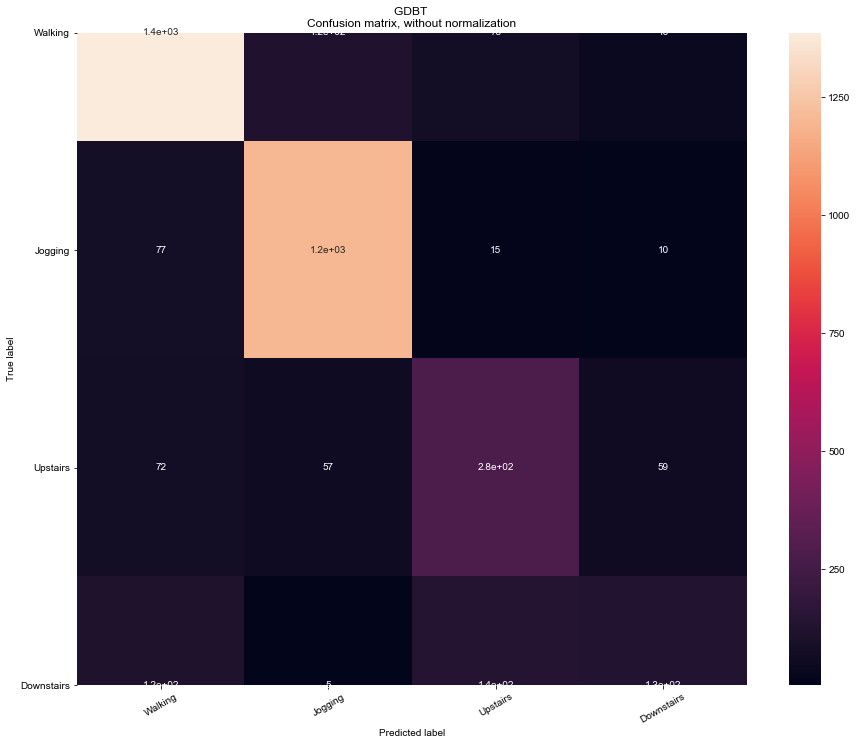

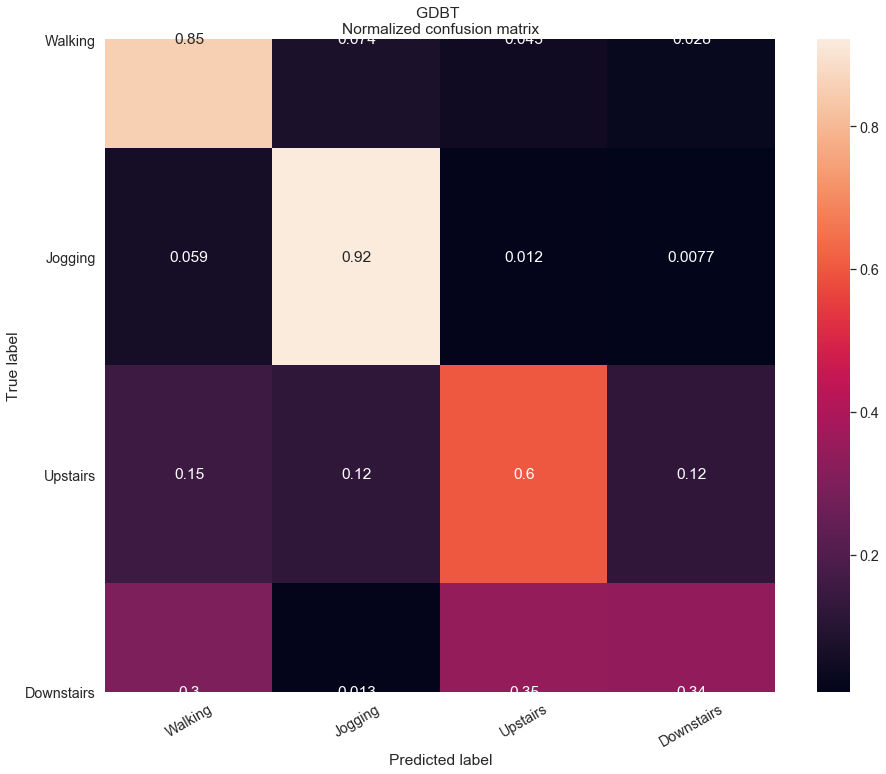


Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1626
           1       0.87      0.92      0.89      1302
           2       0.56      0.60      0.58       473
           3       0.54      0.34      0.42       390

    accuracy                           0.79      3791
   macro avg       0.70      0.68      0.68      3791
weighted avg       0.78      0.79      0.79      3791



In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sb
from sklearn.utils.multiclass import unique_labels

target_names = ['Walking','Jogging','Upstairs', 'Downstairs']

y_pred = clf1.predict(test_features)
lables = np.concatenate([target_names, ])
1

from sklearn.metrics import f1_score

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False, title=None):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    #metrics.f1_score(y_test, y_pred, labels=np.unique(y_pred))
    
    fig, ax = plt.subplots(figsize = (15,12))
    #Create a 2-dim array include: rows, columns, data
    dataFrame = pd.DataFrame(cm)
    #create a heatmap, annot = True: add text on each cell over heatmap
    sb.heatmap(dataFrame, annot = True)  
    ax.set(xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    sb.set(font_scale = 1.3)

np.set_printoptions(precision=2) #lam tron

plot_confusion_matrix(test_label, y_pred, classes=lables,  
        title='GDBT \nConfusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test_label, y_pred, classes=lables, normalize=True,
        title='GDBT \nNormalized confusion matrix')

plt.show()
print ("\nClassification Report: ")
print (classification_report(test_label, y_pred,labels=np.unique(y_pred)))
